In [20]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

In [46]:
import numpy as np
import pandas as pd
from matplotlib import style
import datetime
import pandas_datareader.data as web
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [47]:
# Get the stock data using yahoo API:
# get 2009-2019 data to train our model
train_data = web.DataReader('BBCA.JK', 'yahoo', datetime.datetime(2010,1,4),datetime.datetime(2019,12,1)) 

# get 2020 data to present date to test the SVM model
# test_data = web.DataReader('BBCA.JK', 'yahoo',  datetime.datetime(2020,1,2), datetime.date.today()) 
test_data = web.DataReader('BBCA.JK', 'yahoo',  datetime.datetime(2020,1,4), datetime.datetime(2021,12,1)) 

In [48]:
train_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,1010.0,965.0,1010.0,1010.0,77812500.0,855.341125
2010-01-05,1020.0,990.0,1020.0,1020.0,44442500.0,863.809998
2010-01-06,1020.0,990.0,990.0,990.0,27782500.0,838.403748
2010-01-07,995.0,965.0,995.0,995.0,38632500.0,842.638123
2010-01-08,995.0,970.0,970.0,970.0,27427500.0,821.466431
...,...,...,...,...,...,...
2019-11-26,6330.0,6270.0,6330.0,6285.0,192783500.0,6034.974609
2019-11-27,6300.0,6240.0,6270.0,6300.0,58833500.0,6049.378418
2019-11-28,6295.0,6245.0,6295.0,6250.0,44248000.0,6001.366699


In [49]:
test_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-06,6750.0,6690.0,6720.0,6735.0,27300000.0,6487.538086
2020-01-07,6770.0,6730.0,6735.0,6740.0,45022500.0,6492.354492
2020-01-08,6745.0,6670.0,6670.0,6680.0,53692500.0,6434.559570
2020-01-09,6755.0,6730.0,6740.0,6740.0,40363500.0,6492.354492
2020-01-10,6825.0,6710.0,6765.0,6725.0,73362000.0,6477.905762
...,...,...,...,...,...,...
2021-11-26,7450.0,7250.0,7400.0,7275.0,113288400.0,7275.000000
2021-11-29,7425.0,7175.0,7275.0,7400.0,87907900.0,7400.000000
2021-11-30,7425.0,7275.0,7325.0,7275.0,144923700.0,7275.000000


In [50]:
# sort by date
train_data = train_data.sort_values('Date')
test_data = test_data.sort_values('Date')

# fix the date 
train_data.reset_index(inplace=True)
train_data.set_index("Date", inplace=True)
test_data.reset_index(inplace=True)
test_data.set_index("Date", inplace=True)

In [51]:
train_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,1010.0,965.0,1010.0,1010.0,77812500.0,855.341125
2010-01-05,1020.0,990.0,1020.0,1020.0,44442500.0,863.809998
2010-01-06,1020.0,990.0,990.0,990.0,27782500.0,838.403748
2010-01-07,995.0,965.0,995.0,995.0,38632500.0,842.638123
2010-01-08,995.0,970.0,970.0,970.0,27427500.0,821.466431
...,...,...,...,...,...,...
2019-11-26,6330.0,6270.0,6330.0,6285.0,192783500.0,6034.974609
2019-11-27,6300.0,6240.0,6270.0,6300.0,58833500.0,6049.378418
2019-11-28,6295.0,6245.0,6295.0,6250.0,44248000.0,6001.366699


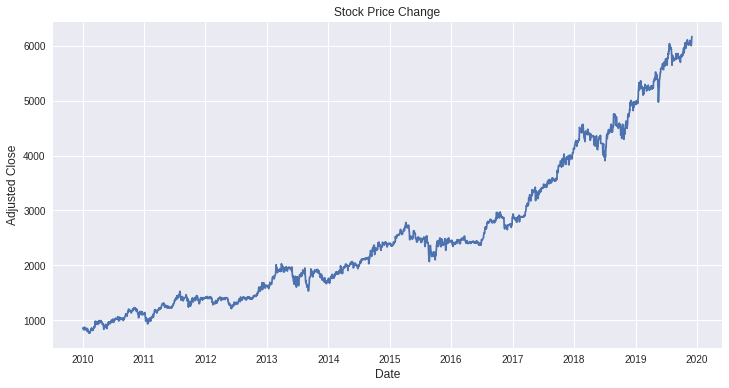

In [52]:
from matplotlib import pyplot as plt

style.use('seaborn')
plt.figure(figsize = (12,6))
plt.plot(train_data["Adj Close"])
plt.title("Stock Price Change")
plt.xlabel("Date", fontsize = 12)
plt.ylabel("Adjusted Close", fontsize = 12)
plt.show()

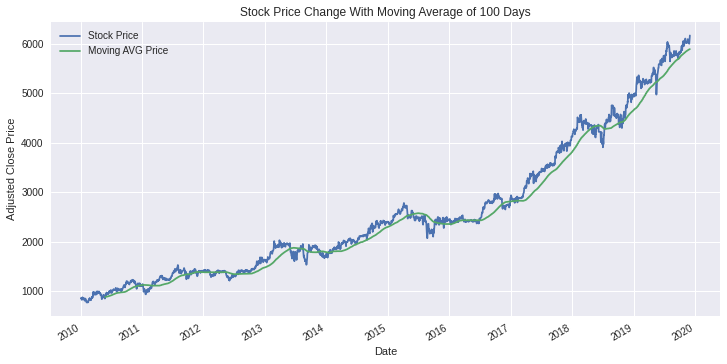

In [53]:
# Rolling mean
close_price = train_data['Adj Close']
moving_avg = close_price.rolling(window=100).mean()

plt.figure(figsize = (12,6))
plt.title("Stock Price Change With Moving Average of 100 Days")
close_price.plot(label='Stock Price')
moving_avg.plot(label='Moving AVG Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()

In [54]:
import matplotlib.dates as mdates

# change the dates into ints for training 
indxed_dates = train_data.copy()
indxed_dates = indxed_dates.reset_index()

# Store the original dates for plotting the predicitons
actual_dates = indxed_dates['Date']

# convert to ints
indxed_dates['Date'] = indxed_dates['Date'].map(mdates.date2num)

indxed_dates

,Date,High,Low,Open,Close,Volume,Adj Close
0,733776.0,1010.0,965.0,1010.0,1010.0,77812500.0,855.341125
1,733777.0,1020.0,990.0,1020.0,1020.0,44442500.0,863.809998
2,733778.0,1020.0,990.0,990.0,990.0,27782500.0,838.403748
3,733779.0,995.0,965.0,995.0,995.0,38632500.0,842.638123
4,733780.0,995.0,970.0,970.0,970.0,27427500.0,821.466431
...,...,...,...,...,...,...,...
2467,737389.0,6330.0,6270.0,6330.0,6285.0,192783500.0,6034.974609
2468,737390.0,6300.0,6240.0,6270.0,6300.0,58833500.0,6049.378418
2469,737391.0,6295.0,6245.0,6295.0,6250.0,44248000.0,6001.366699
2470,737392.0,6295.0,6225.0,6230.0,6280.0,52954500.0,6030.173828


In [55]:
# Use sklearn support vector regression to predicit our data:
from sklearn.svm import SVR

dates_data = indxed_dates['Date'].to_numpy()
prices_data = train_data['Adj Close'].to_numpy()

#Convert to 1d Vector
dates_data = np.reshape(dates_data, (len(dates_data), 1))
prices_data = np.reshape(prices_data, (len(prices_data), 1))

In [56]:
SVR_linear = make_pipeline(StandardScaler(), SVR(kernel='linear', C=1))
SVR_linear.fit(dates_data, prices_data)
SVR_linear_train = SVR_linear.predict(dates_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [57]:
SVR_linear_train

array([ 824.88603027,  825.7225007 ,  826.55897112, ..., 3848.72662044,
       3849.56309087, 3852.07250214])

In [58]:
SVR_rbfk = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
SVR_rbfk.fit(dates_data, prices_data)
SVR_rbfk_train = SVR_rbfk.predict(dates_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [59]:
SVR_rbfk_train

array([1002.15056696,  863.90978899,  838.30375966, ..., 5911.47796494,
       5592.15331822, 4232.57414451])

In [60]:
SVR_poly = make_pipeline(StandardScaler(), SVR(kernel='poly', C=1e3, degree=3, epsilon=0.1, coef0=1))
SVR_poly.fit(dates_data, prices_data)
SVR_poly_train = SVR_poly.predict(dates_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [61]:
SVR_poly_train

array([ 785.67538399,  786.87210203,  788.06761518, ..., 6196.41270259,
       6200.68962192, 6213.53784527])

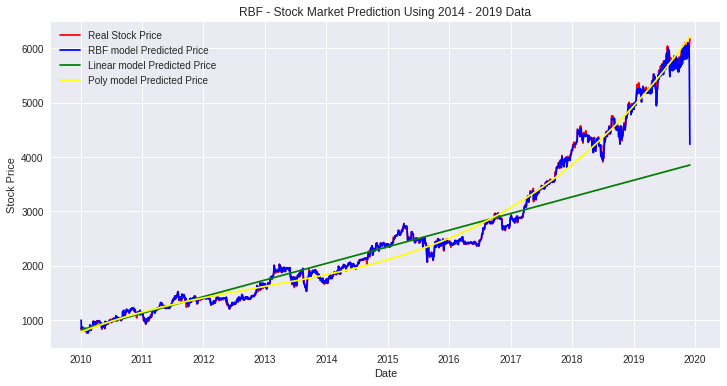

In [62]:
plt.figure(figsize = (12,6))
plt.title('RBF - Stock Market Prediction Using 2014 - 2019 Data')
plt.plot(dates_data, prices_data, color= 'red', label= 'Real Stock Price')
plt.plot(actual_dates, SVR_rbfk_train, color= 'blue', label= 'RBF model Predicted Price') 
plt.plot(actual_dates, SVR_linear_train, color= 'green', label= 'Linear model Predicted Price') 
plt.plot(actual_dates, SVR_poly_train, color= 'yellow', label= 'Poly model Predicted Price') 
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [63]:
# change the dates into ints for training 
test_indxed_dates = test_data.copy()
test_indxed_dates = test_indxed_dates.reset_index()

# Store the original dates for plotting the predicitons
test_actual_dates = test_indxed_dates['Date']

# convert to ints
test_indxed_dates['Date'] = test_indxed_dates['Date'].map(mdates.date2num)

In [64]:
test_indxed_dates

,Date,High,Low,Open,Close,Volume,Adj Close
0,737430.0,6750.0,6690.0,6720.0,6735.0,27300000.0,6487.538086
1,737431.0,6770.0,6730.0,6735.0,6740.0,45022500.0,6492.354492
2,737432.0,6745.0,6670.0,6670.0,6680.0,53692500.0,6434.559570
3,737433.0,6755.0,6730.0,6740.0,6740.0,40363500.0,6492.354492
4,737434.0,6825.0,6710.0,6765.0,6725.0,73362000.0,6477.905762
...,...,...,...,...,...,...,...
462,738120.0,7450.0,7250.0,7400.0,7275.0,113288400.0,7275.000000
463,738123.0,7425.0,7175.0,7275.0,7400.0,87907900.0,7400.000000
464,738124.0,7425.0,7275.0,7325.0,7275.0,144923700.0,7275.000000
465,738125.0,7450.0,7275.0,7275.0,7300.0,76538100.0,7300.000000


In [65]:
test_dates_data = test_indxed_dates['Date'].to_numpy()
test_prices_data = test_data['Adj Close'].to_numpy()

#Convert to 1d Vector
test_dates_data = np.reshape(test_dates_data, (len(test_dates_data), 1))
test_prices_data = np.reshape(test_prices_data, (len(test_prices_data), 1))

In [ ]:
SVR_rbfk = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
SVR_rbfk.fit(test_dates_data, test_prices_data)
SVR_rbfk_test = SVR_rbfk.predict(test_dates_data)
SVR_rbfk_test

In [ ]:
SVR_linear = make_pipeline(StandardScaler(), SVR(kernel='linear', C=1))
SVR_linear.fit(test_dates_data, test_prices_data)
SVR_linear_test =  SVR_linear.predict(test_dates_data)
SVR_linear_test

In [ ]:
SVR_poly = make_pipeline(StandardScaler(), SVR(kernel='poly', C=1e3, degree=3, epsilon=0.1, coef0=1))
SVR_poly.fit(test_dates_data, test_prices_data)
SVR_poly_test = SVR_poly.predict(test_dates_data)
SVR_poly_test

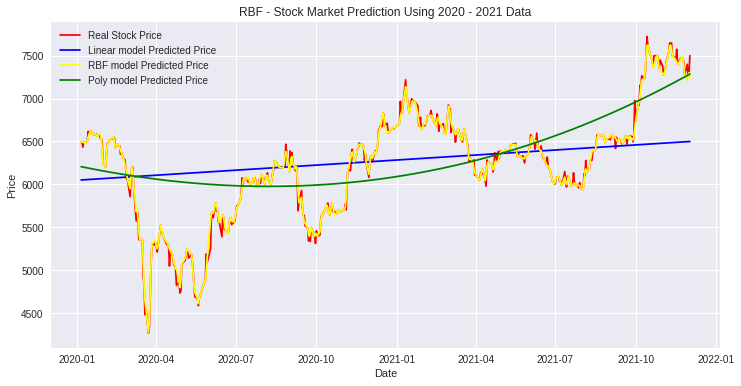

In [69]:
plt.figure(figsize = (12,6))
plt.title('RBF - Stock Market Prediction Using 2020 - 2021 Data')
plt.plot(test_dates_data, test_prices_data, color= 'red', label= 'Real Stock Price')
plt.plot(test_actual_dates, SVR_linear_test, color= 'blue', label= 'Linear model Predicted Price')
plt.plot(test_actual_dates, SVR_rbfk_test, color= 'yellow', label= 'RBF model Predicted Price')
plt.plot(test_actual_dates, SVR_poly_test, color= 'green', label= 'Poly model Predicted Price') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [70]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print("SVR RBF Train RMSE: %.2f"
      % np.sqrt(mean_squared_error(prices_data, SVR_rbfk_train)))

print("SVR RBF Train R2 Score: %.2f"
      % r2_score(prices_data, SVR_rbfk_train))

print("SVR RBF Train MAE Score: %.2f"
      % mean_absolute_error(prices_data, SVR_rbfk_train))

print("SVR RBF Test RMSE: %.2f"
      % np.sqrt(mean_squared_error(test_prices_data, SVR_rbfk_test)))

print("SVR RBF Test R2 Score: %.2f"
      % r2_score(test_prices_data, SVR_rbfk_test))

print("SVR RBF Test MAE Score: %.2f"
      % mean_absolute_error(test_prices_data, SVR_rbfk_test))


SVR RBF Train RMSE: 53.71
SVR RBF Train R2 Score: 1.00
SVR RBF Train MAE Score: 14.36
SVR RBF Test RMSE: 54.45
SVR RBF Test R2 Score: 0.99
SVR RBF Test MAE Score: 25.97


In [71]:
print("SVR Linear Train RMSE: %.2f"
      % np.sqrt(mean_squared_error(prices_data, SVR_linear_train)))

print("SVR Linear Train R2 Score: %.2f"
      % r2_score(prices_data, SVR_linear_train))

print("SVR Linear Train MAE Score: %.2f"
      % mean_absolute_error(prices_data, SVR_linear_train))

print("SVR Linear Test RMSE: %.2f"
      % np.sqrt(mean_squared_error(test_prices_data, SVR_linear_test)))

print("SVR Linear Test R2 Score: %.2f"
      % r2_score(test_prices_data, SVR_linear_test))

print("SVR Linear Test MAE Score: %.2f"
      % mean_absolute_error(test_prices_data, SVR_linear_test))

SVR Linear Train RMSE: 703.80
SVR Linear Train R2 Score: 0.75
SVR Linear Train MAE Score: 419.18
SVR Linear Test RMSE: 572.66
SVR Linear Test R2 Score: 0.21
SVR Linear Test MAE Score: 442.54


In [72]:
print("SVR Poly Train RMSE: %.2f"
      % np.sqrt(mean_squared_error(prices_data, SVR_poly_train)))

print("SVR Poly Train R2 Score: %.2f"
      % r2_score(prices_data, SVR_poly_train))

print("SVR Poly Train MAE Score: %.2f"
      % mean_absolute_error(prices_data, SVR_poly_train))

print("SVR Poly Test RMSE: %.2f"
      % np.sqrt(mean_squared_error(test_prices_data, SVR_poly_test)))

print("SVR Poly Test R2 Score: %.2f"
      % r2_score(test_prices_data, SVR_poly_test))

print("SVR Poly Test MAE Score: %.2f"
      % mean_absolute_error(test_prices_data, SVR_poly_test))

SVR Poly Train RMSE: 172.68
SVR Poly Train R2 Score: 0.99
SVR Poly Train MAE Score: 130.61
SVR Poly Test RMSE: 506.87
SVR Poly Test R2 Score: 0.38
SVR Poly Test MAE Score: 407.13
